In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# If running on Windows and you get a BrokenPipeError, try setting
# the num_worker of torch.utils.data.DataLoader() to 0.



## 1. CIFAR10 데이터 로드 및 정규화



In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # 텐서 형태로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화 transform.Normalize(mean, std, inplace(bool))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  dog   dog horse truck



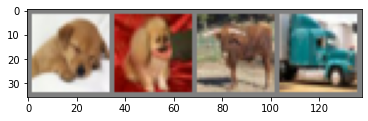

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 # unnormalized,  [-1,1]->[0,1]
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0))) # rgb 차원을 뒤로 보내주기 위함 (3, 36, 138) -> (36, 138, 3)
  

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Convolution Neural Network(CNN) 정의

In [6]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

## 3. Define Loss Function and Optimizer Program

In [7]:
# Classification CrossEntropyLoss, SGD with Momentum
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## 4. Network Traning

In [8]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # 인풋을 가져오자
    inputs, labels = data
    
    # parameter gradients 초기화
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss = loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

print('\nFinished Traning')

[1,  2000] loss: 0.001
[1,  4000] loss: 0.001
[1,  6000] loss: 0.001
[1,  8000] loss: 0.001
[1, 10000] loss: 0.001
[1, 12000] loss: 0.001
[2,  2000] loss: 0.001
[2,  4000] loss: 0.000
[2,  6000] loss: 0.001
[2,  8000] loss: 0.001
[2, 10000] loss: 0.000
[2, 12000] loss: 0.001

Finished Traning


In [9]:
PATH = './cifa_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Network Test in Test dataset

GroundTruth:    cat  ship  ship plane


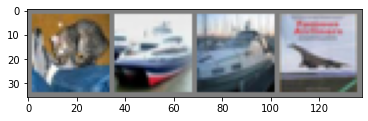

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship  ship


In [13]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
  
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


### 클래스 별 accuracy 출력

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    # print('&&&&&&&&&&&&&&&')
    # print((predicted == labels))
    c = (predicted == labels).squeeze()
    # print(c)
    # print('&&&&&&&&&&&&&&&')
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 70 %
Accuracy of  bird : 41 %
Accuracy of   cat : 47 %
Accuracy of  deer : 30 %
Accuracy of   dog : 47 %
Accuracy of  frog : 61 %
Accuracy of horse : 56 %
Accuracy of  ship : 69 %
Accuracy of truck : 74 %


## GPU Training

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [15]:
net.to(device)

In [16]:
inputs, labels = data[0].to(device), data[1].to(device)